In [2]:
import pyspark
import os.path

In [3]:
sc = pyspark.SparkContext(master="local[1]",appName='metyis_challenge')

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [152]:
# Vamos a definir un schema personalizado para poder tratar las fechas convenientemente
from pyspark.sql.types import *

bixiSchema = StructType([ \
                StructField("_c0", DoubleType(), True), \
                StructField("start_date", DateType(), True), \
                StructField("start_station_code", StringType(), True), \
                StructField("end_date", DateType(), True), \
                StructField("end_station_code", StringType(), True), \
                StructField("duration_sec", DoubleType(), True), \
                StructField("is_member", BooleanType(), True)])

NameError: name 'DateTimeType' is not defined

In [35]:
bixiDF = sqlContext.read.format('csv').options(header='true', delimiter = ',') \
        .load('./data/OD_2014.csv', schema = bixiSchema)

print(bixiDF.count())
bixiDF.take(3)

3136276


[Row(_c0=0.0, start_date=datetime.date(2014, 4, 15), start_station_code='6209', end_date=datetime.date(2014, 4, 15), end_station_code='6436', duration_sec=1061.0, is_member=None),
 Row(_c0=1.0, start_date=datetime.date(2014, 4, 15), start_station_code='6214', end_date=datetime.date(2014, 4, 15), end_station_code='6248', duration_sec=615.0, is_member=None),
 Row(_c0=2.0, start_date=datetime.date(2014, 4, 15), start_station_code='6164', end_date=datetime.date(2014, 4, 15), end_station_code='6216', duration_sec=1031.0, is_member=None)]

In [36]:
bixiDF.describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|              _c0|start_station_code|  end_station_code|     duration_sec|
+-------+-----------------+------------------+------------------+-----------------+
|  count|          3136276|           3136276|           3136276|          3136276|
|   mean|        1568137.5|  6237.94442134557| 6231.226863643378|789.7391029998636|
| stddev|905365.0407640373|273.04065261969197|281.75890464523695|627.6714220519676|
|    min|              0.0|             10002|             10002|             61.0|
|    max|        3136275.0|              6929|              6929|           7195.0|
+-------+-----------------+------------------+------------------+-----------------+



In [37]:
display(bixiDF)

DataFrame[_c0: double, start_date: date, start_station_code: string, end_date: date, end_station_code: string, duration_sec: double, is_member: boolean]

In [38]:
year = '2014'

In [39]:
sqlContext.sql('DROP TABLE IF EXISTS metyis_bixi_travels')
sqlContext.registerDataFrameAsTable(bixiDF, 'metyis_bixi_travels')

In [40]:
# durations = sqlContext.sql('SELECT min(month(start_date)) as month, sum(duration_sec) \
#        FROM metyis_bixi_travels')
# durations.take(10)

[Row(month=4, sum(duration_sec)=2476839795.0)]

In [85]:
durations = sqlContext.sql('SELECT \
        month(start_date) as month, avg(duration_sec) as time \
        FROM metyis_bixi_travels \
        WHERE year(start_date) = {} \
        GROUP BY month(start_date) \
        ORDER BY month'\
        .format(year))
durations.take(10)

[Row(month=4, time=725.5070383506983),
 Row(month=5, time=799.1206648493941),
 Row(month=6, time=832.9655290446372),
 Row(month=7, time=822.1203842262782),
 Row(month=8, time=835.3192805057653),
 Row(month=9, time=761.46314588154),
 Row(month=10, time=694.5260624800343),
 Row(month=11, time=621.2702324203495)]

In [86]:
from matplotlib import pyplot as plt
import pandas as pd

durationsDF = pd.DataFrame(durations.toPandas(), columns=['month', 'time'])
#durationsDF['ts'] = durationsDF["date"].astype("datetime64")
durationsDF.head(10)


# durationsDF.plot.hist(y='ts', x='time')

,month,time
0,4,725.507038
1,5,799.120665
2,6,832.965529
3,7,822.120384
4,8,835.319281
5,9,761.463146
6,10,694.526062
7,11,621.270232


## Histograma de tiempos de viaje para un año dado

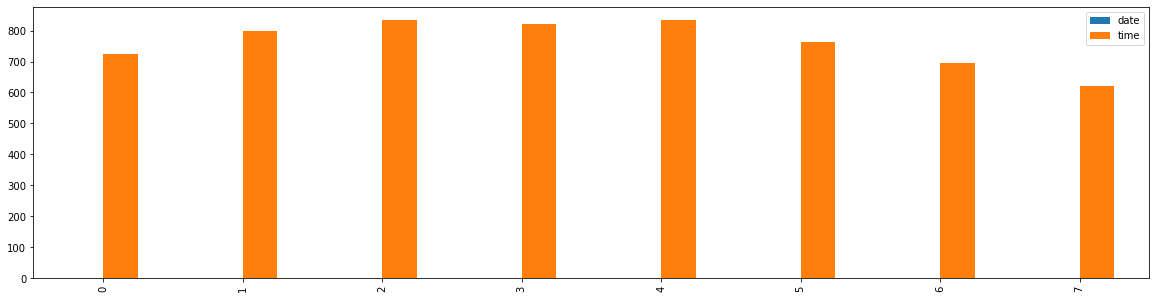

In [81]:
fig, ax = plt.subplots(figsize=(20, 5))

durations_plot = durationsDF.plot(kind="bar",ax=ax)

## Listado del Top N de estaciones más utilizadas para un año dado

### Estaciones de salida

In [120]:
top_stations_departure = sqlContext.sql('SELECT count(_c0) as use, start_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY start_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_stations_departureDF = pd.DataFrame(top_stations_departure.toPandas(), columns=['use', 'start_station_code'])
top_stations_departureDF.head(5)

,use,start_station_code
0,45600,6184
1,33241,6078
2,32055,6064
3,28224,6214
4,27072,6100


### Estaciones de llegada

In [121]:
top_stations_arrival = sqlContext.sql('SELECT count(_c0) as use, end_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY end_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_stations_arrivalDF = pd.DataFrame(top_stations_arrival.toPandas(), columns=['use', 'end_station_code'])
top_stations_arrivalDF.head(5)

,use,end_station_code
0,43765,6184
1,39310,6078
2,34819,6064
3,34664,6012
4,31664,6015


### En general

In [122]:
top_stations_departureDF

,use,start_station_code
0,45600,6184
1,33241,6078
2,32055,6064
3,28224,6214
4,27072,6100
...,...,...
454,187,5004
455,162,6750
456,24,6928
457,22,6240


In [134]:
top_stations = pd.merge(top_stations_departureDF,
                        top_stations_arrivalDF, 
                        left_on = ['start_station_code'], 
                        right_on = ['end_station_code'], 
                        how='outer')

top_stations['total_use'] = top_stations['use_x']+top_stations['use_y']
top_stations[['start_station_code','total_use']].head(5)

,start_station_code,total_use
0,6184,89365
1,6078,72551
2,6064,66874
3,6214,47838
4,6100,53909


## Viajes

In [136]:
top_travels = sqlContext.sql('SELECT count(_c0) as use, start_station_code, end_station_code \
                                        FROM metyis_bixi_travels \
                                        WHERE year(start_date) = {} \
                                        GROUP BY start_station_code, end_station_code \
                                        ORDER BY use DESC'\
                                        .format(year))

top_travels = pd.DataFrame(top_travels.toPandas(), columns=['use', 'start_station_code', 'end_station_code'])
top_travels.head(5)

,use,start_station_code,end_station_code
0,2853,6501,6501
1,1809,6026,6026
2,1670,6155,6184
3,1660,6154,6184
4,1629,6064,6100


In [150]:
rush = sqlContext.sql('SELECT _c0, start_date, dayofweek(start_date), date_format(start_date, "HH:mm") \
                                        FROM metyis_bixi_travels'\
                                        .format(year))
rush.take(50)

[Row(_c0=0.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=1.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=2.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=3.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=4.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=5.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=6.0, start_date=datetime.date(2014, 4, 15), dayofweek(start_date)=3, date_format(CAST(start_date AS TIMESTAMP), HH:mm)='00:00'),
 Row(_c0=7.0, start_date=datetime.